### DCGAN - MNIST dataset

In this notebook we are going to implement the DCGAN using the mnist dataset to generate images. This notebook is based on [this](https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py) repository.

### Imports

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
import sys, os

print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.5.0


### Generator Model.

In this notebook we are going to use `upSampling2D()` in our generator model instead of `conv2DTranspose()` later on we will use the `conv2DTranspose()` to compare the two approaches.

For the last layer we wil be using a `tanh` activation function and for the hidden layers we will be using the `relu` activation function.

In [29]:
class GenBlock(keras.layers.Layer):
  def __init__(self, in_features, kernel_size=3, sampling_size=None, padding="same", momentum=.8):
    super(GenBlock, self).__init__()
    if sampling_size:
        self.up_sampling = keras.layers.UpSampling2D(size=sampling_size)
    else:
      self.up_sampling = keras.layers.UpSampling2D()
    self.conv = keras.layers.Conv2D(in_features, kernel_size=kernel_size, padding=padding)
    self.bn = keras.layers.BatchNormalization(momentum=momentum)
    self.relu = keras.layers.ReLU()

  def call(self, x):
    x = self.up_sampling(x)
    x = self.conv(x)
    x = self.bn(x)
    return self.relu(x)
class GenOutputBlock(keras.layers.Layer):
  def __init__(self, channels=1,  kernel_size=3):
    super(GenOutputBlock, self).__init__(self)

    self.conv = keras.layers.Conv2D(channels, kernel_size=kernel_size, padding='same')
    self.tanh = keras.activations.tanh

  def call(self, x):
    x = self.conv(x)
    return self.tanh(x)

latent_dim = 128
input_dim = 100
channels = 1
gen_model = keras.Sequential([
        keras.layers.Dense(latent_dim * 7 * 7, activation='relu', input_dim=input_dim),
        keras.layers.Reshape((7, 7, latent_dim)),
        GenBlock(128),
        GenBlock(in_features=64),
        GenOutputBlock(channels=channels)
], name="generator_model")

gen_model.build(input_shape=(input_dim, ))
gen_model.summary()

Model: "generator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_18 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
gen_block_20 (GenBlock)      (None, 14, 14, 128)       148096    
_________________________________________________________________
gen_block_21 (GenBlock)      (None, 28, 28, 64)        74048     
_________________________________________________________________
gen_output_block_7 (GenOutpu (None, 28, 28, 1)         577       
Total params: 856,193
Trainable params: 855,809
Non-trainable params: 384
_________________________________________________________________


### Discriminator Model.
In this model we are going to use the `LeakyReLU` activation function for hidden layers and `sigmoid` for  the output layer.

In [32]:
class DBlock(keras.layers.Layer):
  def __init__(self, in_features, kernel_size=3, padding="same", zero_padding=False, momentum=.8,
               alpha=.2, dropout=.25):
    super(DBlock, self).__init__()

    self.zero_padding = zero_padding
    self.conv = keras.layers.Conv2D(in_features, kernel_size=kernel_size,
                                    padding=padding)
    self.zero_padding_layer = keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))
    self.bn = keras.layers.BatchNormalization(momentum=momentum)
    self.leaky_relu = keras.layers.LeakyReLU(alpha=alpha)
    self.dropout = keras.layers.Dropout(rate=dropout)
  
  def call(self, x):
    x = self.dropout(x)
    x = self.conv(x)
    if self.zero_padding:
      x = self.zero_padding_layer(x)
    x = self.bn(x)
    x = self.leaky_relu(x)
    return x

class DOutputBlock(keras.layers.Layer):
  def __init__(self, channels=1, activation='sigmoid', dropout=.25 ):
    super(DOutputBlock, self).__init__()
    self.flatten = keras.layers.Flatten()
    self.fc = keras.layers.Dense(channels, activation=activation)
    self.dropout = keras.layers.Dropout(rate=dropout)

  def call(self, x):
    x = self.dropout(x)
    x = self.flatten(x)
    return self.fc(x)


image_shape = (28, 28, 1)

disc_model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same") ,
    keras.layers.LeakyReLU(alpha=0.2), 
     DBlock(64, zero_padding=True),
     DBlock(128),
     DBlock(256),
     DOutputBlock(1)         
], name="discriminator_model")

disc_model.summary()

Model: "discriminator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
d_block_1 (DBlock)           (None, 15, 15, 64)        18752     
_________________________________________________________________
d_block_2 (DBlock)           (None, 15, 15, 128)       74368     
_________________________________________________________________
d_block_3 (DBlock)           (None, 15, 15, 256)       296192    
_________________________________________________________________
d_output_block (DOutputBlock (None, 1)                 57601     
Total params: 447,233
Trainable params: 446,337
Non-trainable params: 896
_______________________________________

### Generating a single image before training.

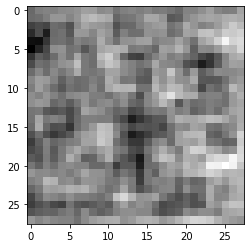

In [37]:
noise = tf.random.normal([1, 100])
generated_image = gen_model(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

### Using the discriminator to identify the generated image before training.

In [38]:
disc_model(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4998558]], dtype=float32)>

### Loss Functions.

If you want explanation on how things are going visit [this](https://github.com/CrispenGari/Keras-API/blob/main/13_Unsupervised_L/01_DC_GANS_01/06_GANS_FaceGeneration_Introduction.ipynb) notebook.

In [85]:
cross_entropy = keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

def generator_loss(fake_output):
  fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return fake_loss

### Optimizers

In [86]:
generator_optimizer = keras.optimizers.Adam(1.5e-4, .5)
discriminator_optimizer = keras.optimizers.Adam(1.5e-4, .5)

### Train step function

In [87]:
BATCH_SIZE = 32
SEED_SIZE = 100
BUFFER_SIZE = 60000

In [99]:
@tf.function
def train_step(images):
  seed = tf.random.normal((BATCH_SIZE, SEED_SIZE))

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = gen_model(seed, training=True)

    real_output = disc_model(images, training= True)
    fake_output = disc_model(generated_images, training=True)

    gen_loss = generator_loss(fake_output=fake_output)
    disc_loss = discriminator_loss(real_output=real_output, fake_output=fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    # UPDATING THE WEIGHTS
    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, gen_model.trainable_variables
    ))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, disc_model.trainable_variables
    ))
    return gen_loss, disc_loss

### Train Function

Saving images.

In [139]:
import os
from PIL import Image
base_path = '/content/drive/MyDrive'
saving_directory = os.path.join(base_path, 'mnist_generated')
if os.path.exists(saving_directory):
  pass
else:
  print("Creating a new directory...")
  os.mkdir(saving_directory)

def save_images(epoch, fixed_seed,  total_per_epoch=3):
  generated_images = gen_model(fixed_seed[:total_per_epoch])
  generated_images = 0.5 * generated_images + 0.5
  generated_images = generated_images * 255
  for index, image_array in enumerate(generated_images):
      filename = os.path.join(saving_directory,f"train_{epoch}_{index}.png")
      im = Image.fromarray(np.array(image_array, dtype=np.uint8))
      im.save(filename)
  print("Total images saved: ", total_per_epoch)

A function that tracks how long training is taking per epoch.

In [140]:
import time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [147]:
def train(dataset, epochs):
  fixed_seed = tf.random.normal([10, SEED_SIZE])
  start = time.time()
  for epoch in range(epochs):
    epoch_start = time.time()
    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_list.append(gen_loss)
      disc_loss_list.append(disc_loss)
    g_loss = sum(gen_loss_list)/len(gen_loss_list)
    d_loss = sum(disc_loss_list)/len(disc_loss_list)

    epoch_end = time.time()
    print (f'Epoch {epoch+1} [ gen loss: {g_loss} ] [ disc loss: {d_loss} ] ETA: {hms_string(epoch_end - epoch_start)}')
    # save_images(epoch=epoch, fixed_seed=fixed_seed, total_per_epoch=5)
  end = time.time()
  print (f'Training time: {hms_string(end - start)}')

### Creating the dataset from the mnist digits datset

In [142]:
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data()

### Plotting Real mnist Digits.

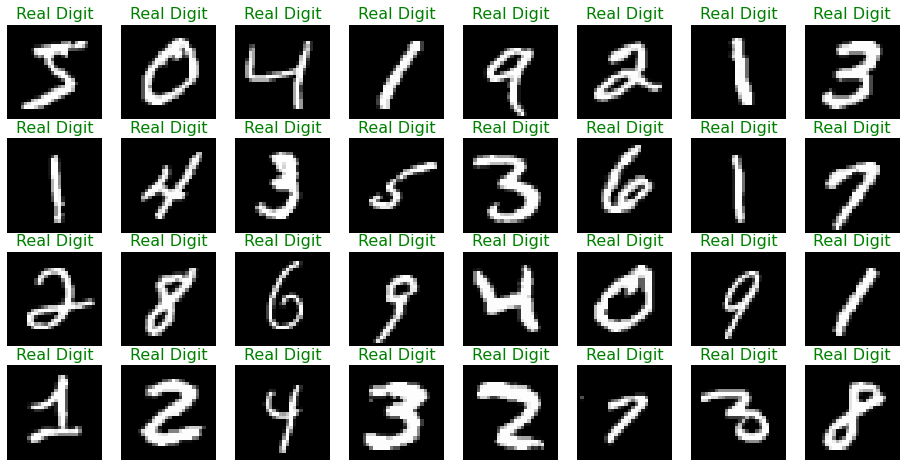

In [143]:
def plot_images(images_and_classes, cols=5):
    rows = 4
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image) in enumerate(images_and_classes):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image, cmap="gray")
        plt.title("Real Digit", color ='g', fontsize=16 )

plot_images(X_train[:32], cols=8)

In [144]:
def reshape_normalize(image):
  image = tf.cast(tf.reshape(image, shape=(28, 28, 1)), dtype=tf.float32)
  image = image / 255.0
  return image

In [145]:
ds = tf.data.Dataset.from_tensor_slices(X_train).map(reshape_normalize).batch(BATCH_SIZE).shuffle(BUFFER_SIZE)

### Training.

Now that we have our data let's train the model.

In [148]:
train(ds, 50)

Epoch 1 [ gen loss: 1.8462138175964355 ] [ disc loss: 1.0646671056747437 ] ETA: 0:00:44.77
Epoch 2 [ gen loss: 1.823251724243164 ] [ disc loss: 1.0738741159439087 ] ETA: 0:00:44.82
Epoch 3 [ gen loss: 1.7982757091522217 ] [ disc loss: 1.0763925313949585 ] ETA: 0:00:44.82
Epoch 4 [ gen loss: 1.775403618812561 ] [ disc loss: 1.090006947517395 ] ETA: 0:00:44.79
Epoch 5 [ gen loss: 1.7728914022445679 ] [ disc loss: 1.0846799612045288 ] ETA: 0:00:44.79
Epoch 6 [ gen loss: 1.7497366666793823 ] [ disc loss: 1.084094524383545 ] ETA: 0:00:44.80
Epoch 7 [ gen loss: 1.719523310661316 ] [ disc loss: 1.0873676538467407 ] ETA: 0:00:44.81
Epoch 8 [ gen loss: 1.7194441556930542 ] [ disc loss: 1.0832035541534424 ] ETA: 0:00:44.81
Epoch 9 [ gen loss: 1.716814637184143 ] [ disc loss: 1.0842676162719727 ] ETA: 0:00:44.78
Epoch 10 [ gen loss: 1.7080111503601074 ] [ disc loss: 1.0814100503921509 ] ETA: 0:00:44.78
Epoch 11 [ gen loss: 1.6985257863998413 ] [ disc loss: 1.0793031454086304 ] ETA: 0:00:44.81
Epo

### Generating images.

In [151]:
seeds = tf.random.normal([32, SEED_SIZE])
generated = gen_model(seeds)

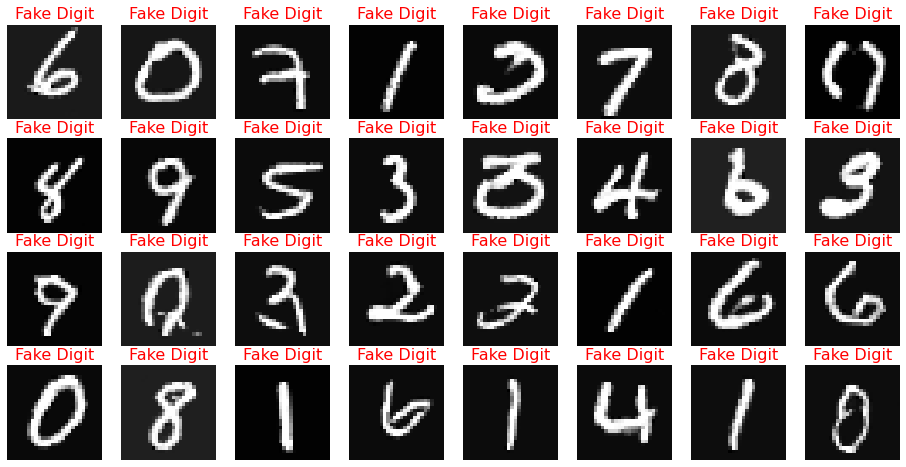

In [155]:
def plot_images(images_and_classes, cols=5):
    rows = 4
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image) in enumerate(images_and_classes):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(np.array(image.numpy() * 255, np.int32)[:, :, 0] , cmap="gray")
        plt.title("Fake Digit", color ='r', fontsize=16 )

plot_images(generated[:], cols=8)